In [71]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import earthkit.data

In [72]:
## updated for HEF
lat = 46.79
lng = 10.74

variable = "total_precipitation"
date_range = ["1940-01-01", "2100-12-31"]

In [1]:
def retrieve_data(variable, date_range, lat, lng):
    # Define the dataset and request parameters
    dataset = "reanalysis-era5-single-levels-timeseries"
    request = {
        "variable": [
        variable,  # Variable to retrieve
        ],
        "date": date_range,  # Date range for the data
        "location": {"longitude": lng, "latitude": lat},  # Location coordinates
        "data_format": "netcdf"  # Format of the retrieved data
    }

    # Use "earthkit" to retrieve the data
    ekds = earthkit.data.from_source(
        "cds", dataset, request
    ).to_xarray()

    return ekds

In [13]:
data = retrieve_data(variable, date_range, lat, lng)

2025-04-17 12:33:59,821 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 12:33:59,824 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 12:33:59,961 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-04-17 12:33:59,963 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-04-17 12:34:00,194 WARNING [2025-03-17T00:00:00] Please be aware that the generation of this dataset 

c7d2368375ba054765e6023f60b44f9f.zip:   0%|          | 0.00/8.57M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [73]:
import xarray as xr


# Join the dates into a string, separated by 'to' (e.g., '1940-01-01_to_2100-12-31')
date_range_str = f"{date_range[0]}_to_{date_range[1]}"

# Create the filename
file_name = f"era5_data/era5_{variable}_{date_range_str}_lat_{lat}_lng_{lng}.nc"

# Save xarray Dataset to a NetCDF file
data.to_netcdf(file_name)

# Load the dataset back from the NetCDF file
dataset_from_netcdf = xr.open_dataset(file_name)


PermissionError: [Errno 13] Permission denied: b'/home/pcuser/hef/era5_data/era5_total_precipitation_1940-01-01_to_2100-12-31_lat_46.79_lng_10.74.nc'

In [74]:
# Load the dataset back from the NetCDF file
data = xr.open_dataset(file_name)

In [89]:
def truncate_data(var):
    """
    Truncate the input dataset to include only complete years where the final hour
    of December 31st is present in the dataset.

    Args:
        var (xarray.Dataset or xarray.DataArray): Input dataset containing a 'valid_time'
                                                  coordinate with datetime information.

    Returns:
        xarray.Dataset or xarray.DataArray: The truncated dataset containing data
                                            only for complete years.
    """
    # Create a range of the final hours of each year in the dataset
    start_year = var.valid_time.dt.year.min().item()
    end_year = var.valid_time.dt.year.max().item()

    final_hours = pd.date_range(
        f"{start_year}-12-31T23:00:00", 
        f"{end_year}-12-31T23:00:00", 
        freq="YE"
    )

    # Filter only the years where the final hour is in the dataset
    valid_years = [
        dt.year for dt in final_hours if dt in var.valid_time
    ]

    # Select data for those years
    var_truncated = var.sel(
        valid_time=var.valid_time.dt.year.isin(valid_years)
    )

    return var_truncated


# Function to compute the annual mean precipitation time series
def precipAnnualTimeseries():
    """
    Processes the annual timeseries of precipitation data.

    This function reads precipitation data from a NetCDF file, removes data
    for the incomplete current year, resamples the data to annual sums, and
    converts the values to millimeters.

    Returns:
        tuple: A tuple containing two elements:
            - years (numpy.ndarray): Years corresponding to the annual precip sums.
            - values (numpy.ndarray): Annual precipitation sums in millimeters.
    """
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to annual sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(
        valid_time="YE"
    ).sum() * 1000

    years = data_tp_pt_agg.valid_time.to_index().year
    values = data_tp_pt_agg.values.flatten()

    # Get the actual lat/lon used
    nearest_lat = data_tp_pt.latitude.values
    nearest_lng = data_tp_pt.longitude.values

    return years, values, nearest_lat, nearest_lng

def precipHydroyearTimeseries():
    """
    Processes the annual timeseries of precipitation data.

    This function reads precipitation data from a NetCDF file, removes data
    for the incomplete current year, resamples the data to annual sums, and
    converts the values to millimeters.

    Returns:
        tuple: A tuple containing two elements:
            - years (numpy.ndarray): Years corresponding to the annual precip sums.
            - values (numpy.ndarray): Annual precipitation sums in millimeters.
    """
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to annual sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(
        valid_time="YE-SEP"  ## Check this is right.
    ).sum() * 1000

    years = data_tp_pt_agg.valid_time.to_index().year # 2023/2024 year is 2024 hydro year.
    values = data_tp_pt_agg.values.flatten()

    # Get the actual lat/lon used
    nearest_lat = data_tp_pt.latitude.values
    nearest_lng = data_tp_pt.longitude.values

    return years, values, nearest_lat, nearest_lng


def precipMonthlyTimeseries():
    """
    Processes the monthly timeseries of precipitation data.

    This function reads precipitation data from a NetCDF file, removes data
    for the incomplete current year, resamples the data to monthly sums, and
    converts the values to millimeters.

    Returns:
        pandas.DataFrame: A DataFrame containing columns for year, month,
                          hydrological year (calendar_year), and the monthly
                          precipitation values.
    """
    data_tp_pt = data.tp

    # Remove incomplete years
    data_tp_pt_trun = truncate_data(data_tp_pt)

    # Resample the data to monthly sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(
        valid_time="MS"  # Resample by calendar month start
    ).sum() * 1000

    # Extract months, years, and values
    months = data_tp_pt_agg.valid_time.to_index().month
    years = data_tp_pt_agg.valid_time.to_index().year
    values = data_tp_pt_agg.values.flatten()

    # Create the DataFrame
    df = pd.DataFrame({
        'year': years,
        'month': months,
        'precipitation_mm': values,
    })

    # Add hydrological-style calendar year (starts in Oct)
    df['calendar_year'] = df.apply(
        lambda row: row['year'] + 1 if row['month'] >= 10 else row['year'],
        axis=1
    )

    # Get the actual lat/lon used
    nearest_lat = data_tp_pt.latitude.values
    nearest_lng = data_tp_pt.longitude.values

    # Add lat/lon to the DataFrame
    df['latitude'] = nearest_lat
    df['longitude'] = nearest_lng

    return df



# Example of how to call the function and inspect the result
df_monthly = precipMonthlyTimeseries()
df_monthly['Date'] = pd.to_datetime(df_monthly[['year', 'month']].assign(day=1))

print(df_monthly)


# Create the filename
file_name_monthly_df = f"era5_data/era5_monthly{variable}_{date_range_str}_lat_{lat}_lng_{lng}.pkl"
df_monthly.to_pickle(file_name_monthly_df)



# Pivot to get monthly precip as columns (1–12)
# ## CAREFUL AS CALENDAR YEAR IS ACTUALLY THE HYDRO YEAR

# df_pivot = df_precip.pivot(index='calendar_year', columns='month', values='precipitation_mm')

# # Rename columns to month names for clarity
# df_pivot.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
#                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# print(df_pivot)




      year  month  precipitation_mm  calendar_year  latitude  longitude  \
0     1940      1         20.965576         1940.0     46.75      10.75   
1     1940      2         43.271782         1940.0     46.75      10.75   
2     1940      3         41.060448         1940.0     46.75      10.75   
3     1940      4         70.344208         1940.0     46.75      10.75   
4     1940      5        111.400368         1940.0     46.75      10.75   
...    ...    ...               ...            ...       ...        ...   
1015  2024      8         46.393394         2024.0     46.75      10.75   
1016  2024      9        130.291931         2024.0     46.75      10.75   
1017  2024     10        121.397018         2025.0     46.75      10.75   
1018  2024     11         31.334400         2025.0     46.75      10.75   
1019  2024     12         60.023308         2025.0     46.75      10.75   

           Date  
0    1940-01-01  
1    1940-02-01  
2    1940-03-01  
3    1940-04-01  
4    1940

In [81]:
df_hef_MB = pd.read_pickle("hef_MB.pkl")

# print(df_hef_MB.head())
# print(df_hef_MB.columns)


df_merged = df_monthly.merge(df_hef_MB, on="calendar_year")




# print(df_merged)

# df_merged = df_merged.dropna(subset=["precipitation_mm", "climatic mass balance"])

print(df_merged)

df_merged = df_merged.dropna(subset=["precipitation_mm", "climatic mass balance"])
print(df_merged)







     year  month  precipitation_mm  calendar_year  latitude  longitude  \
0    1953     10        112.755058         1954.0     46.75      10.75   
1    1953     11          6.618500         1954.0     46.75      10.75   
2    1953     12         22.446394         1954.0     46.75      10.75   
3    1954      1         94.801903         1954.0     46.75      10.75   
4    1954      2         25.869370         1954.0     46.75      10.75   
..    ...    ...               ...            ...       ...        ...   
847  2024      5        154.816147         2024.0     46.75      10.75   
848  2024      6        121.142868         2024.0     46.75      10.75   
849  2024      7         52.457809         2024.0     46.75      10.75   
850  2024      8         46.393394         2024.0     46.75      10.75   
851  2024      9        130.291931         2024.0     46.75      10.75   

          Date hydrological year  mean specific mass balance  \
0   1953-10-01         1953/1954               

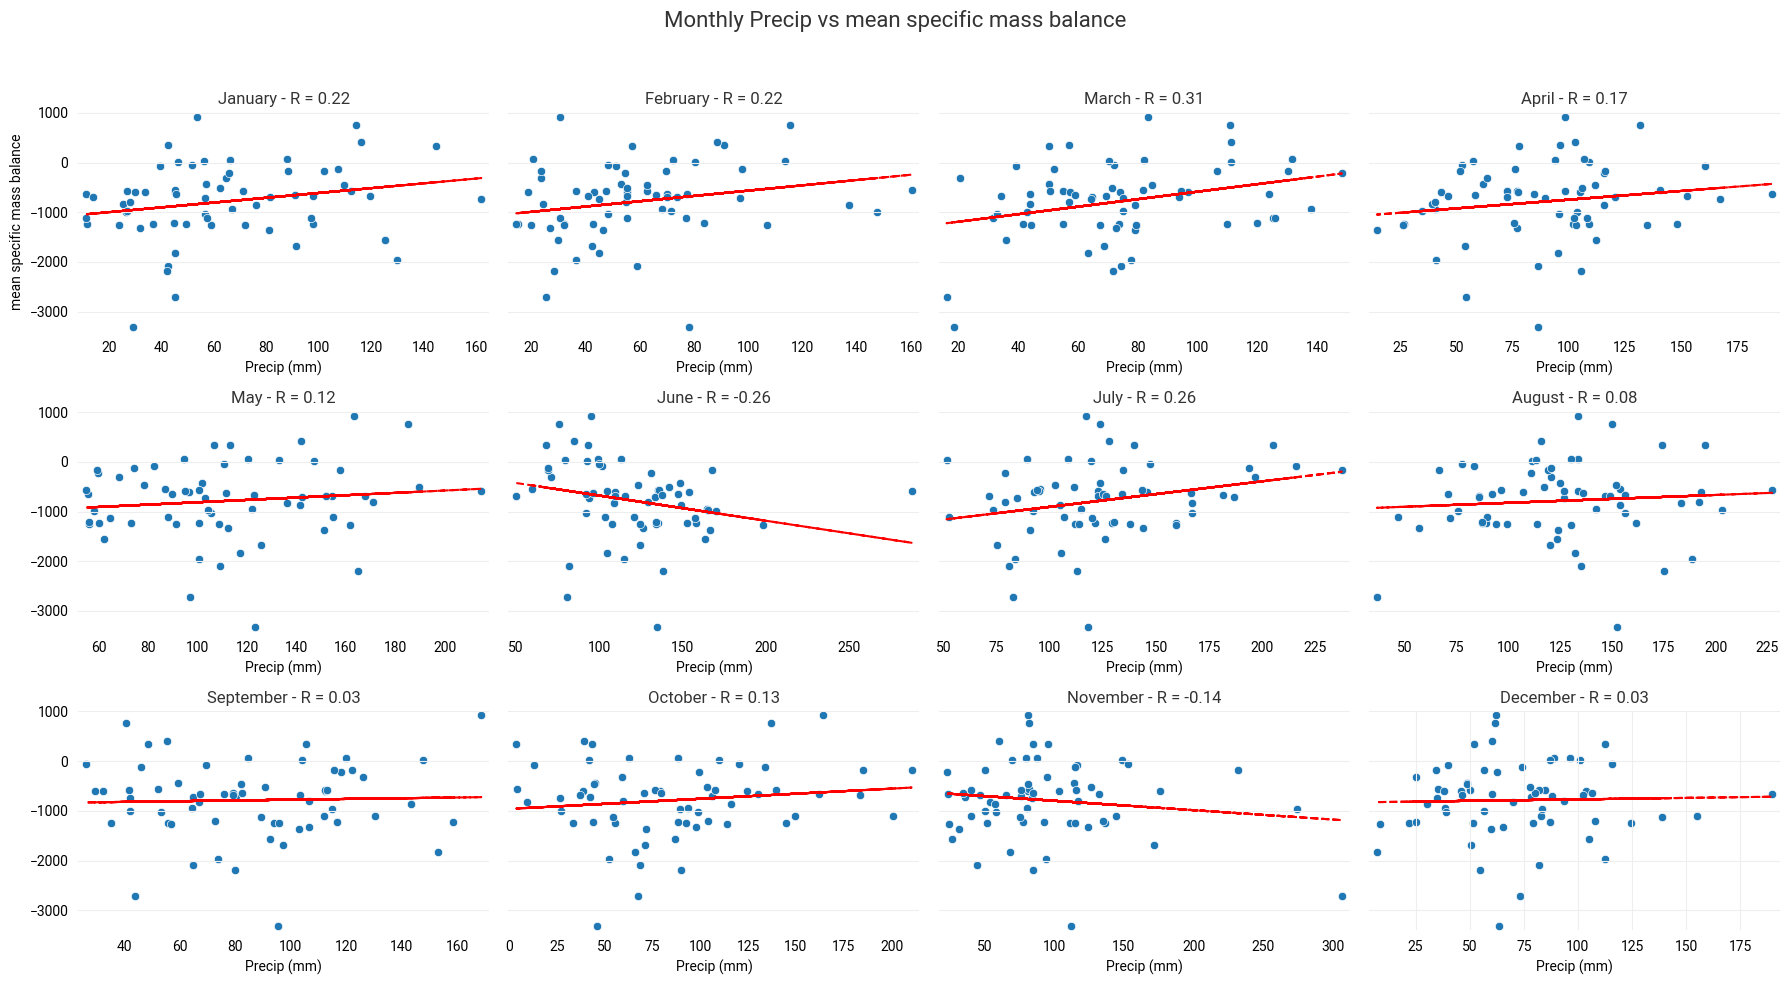

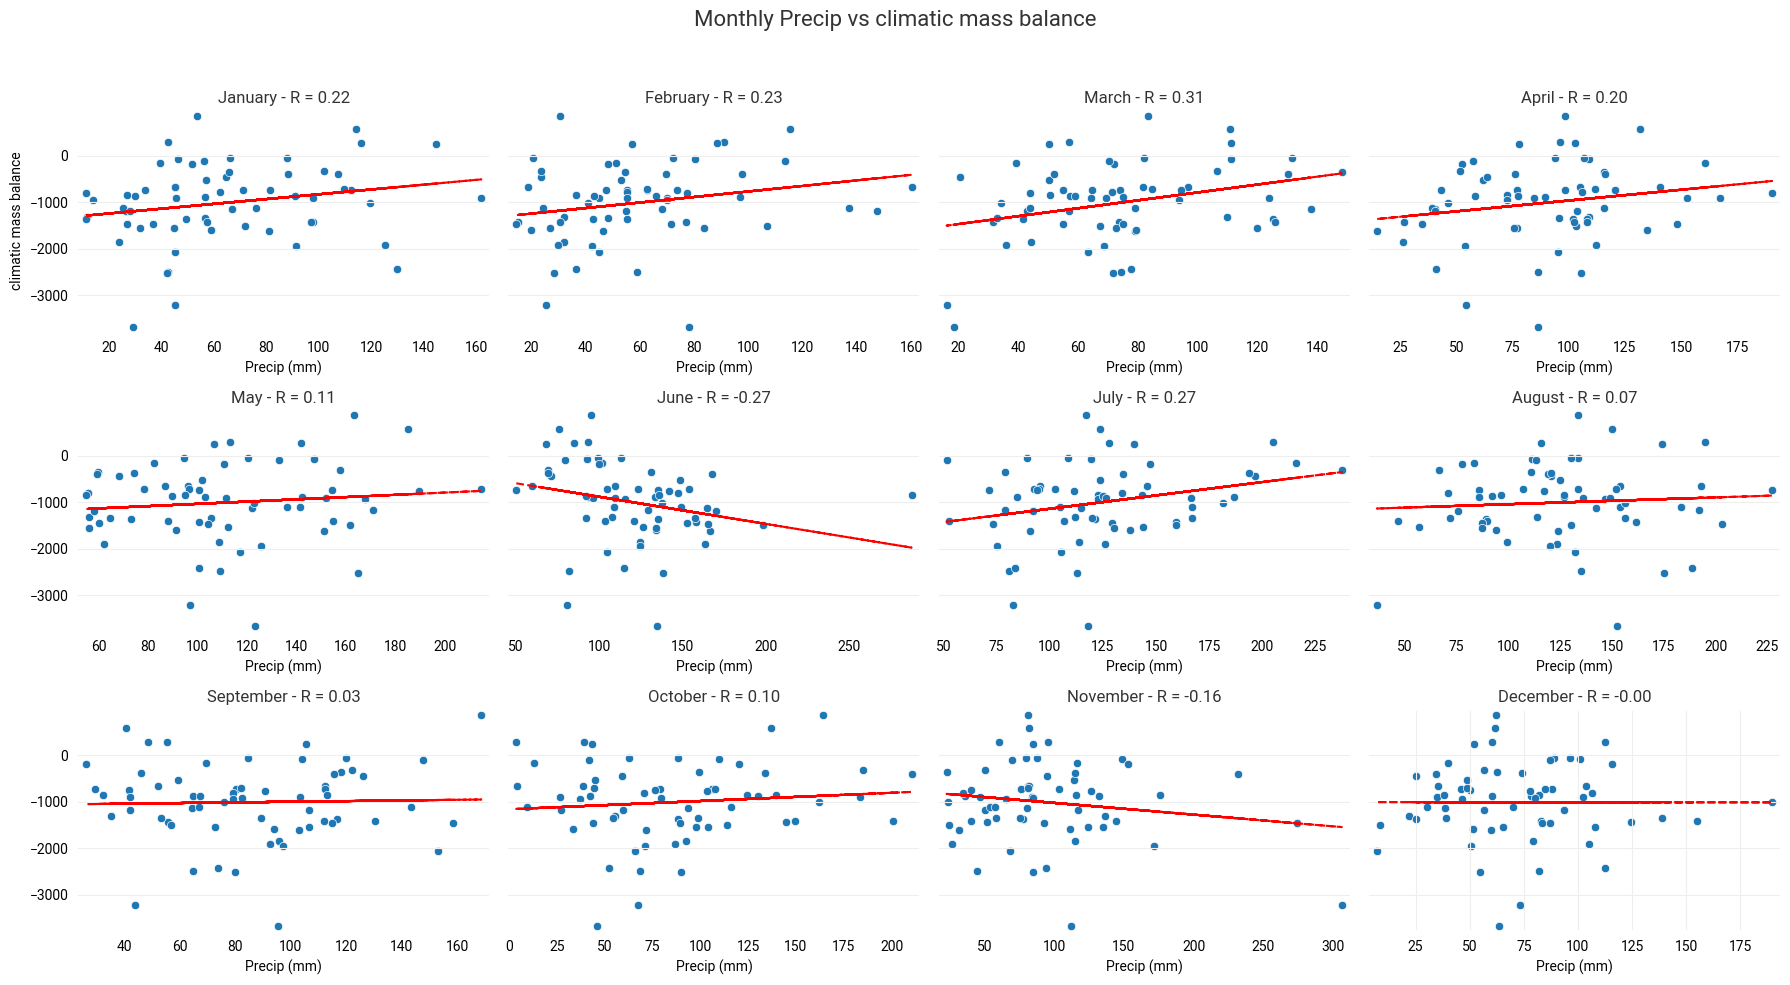

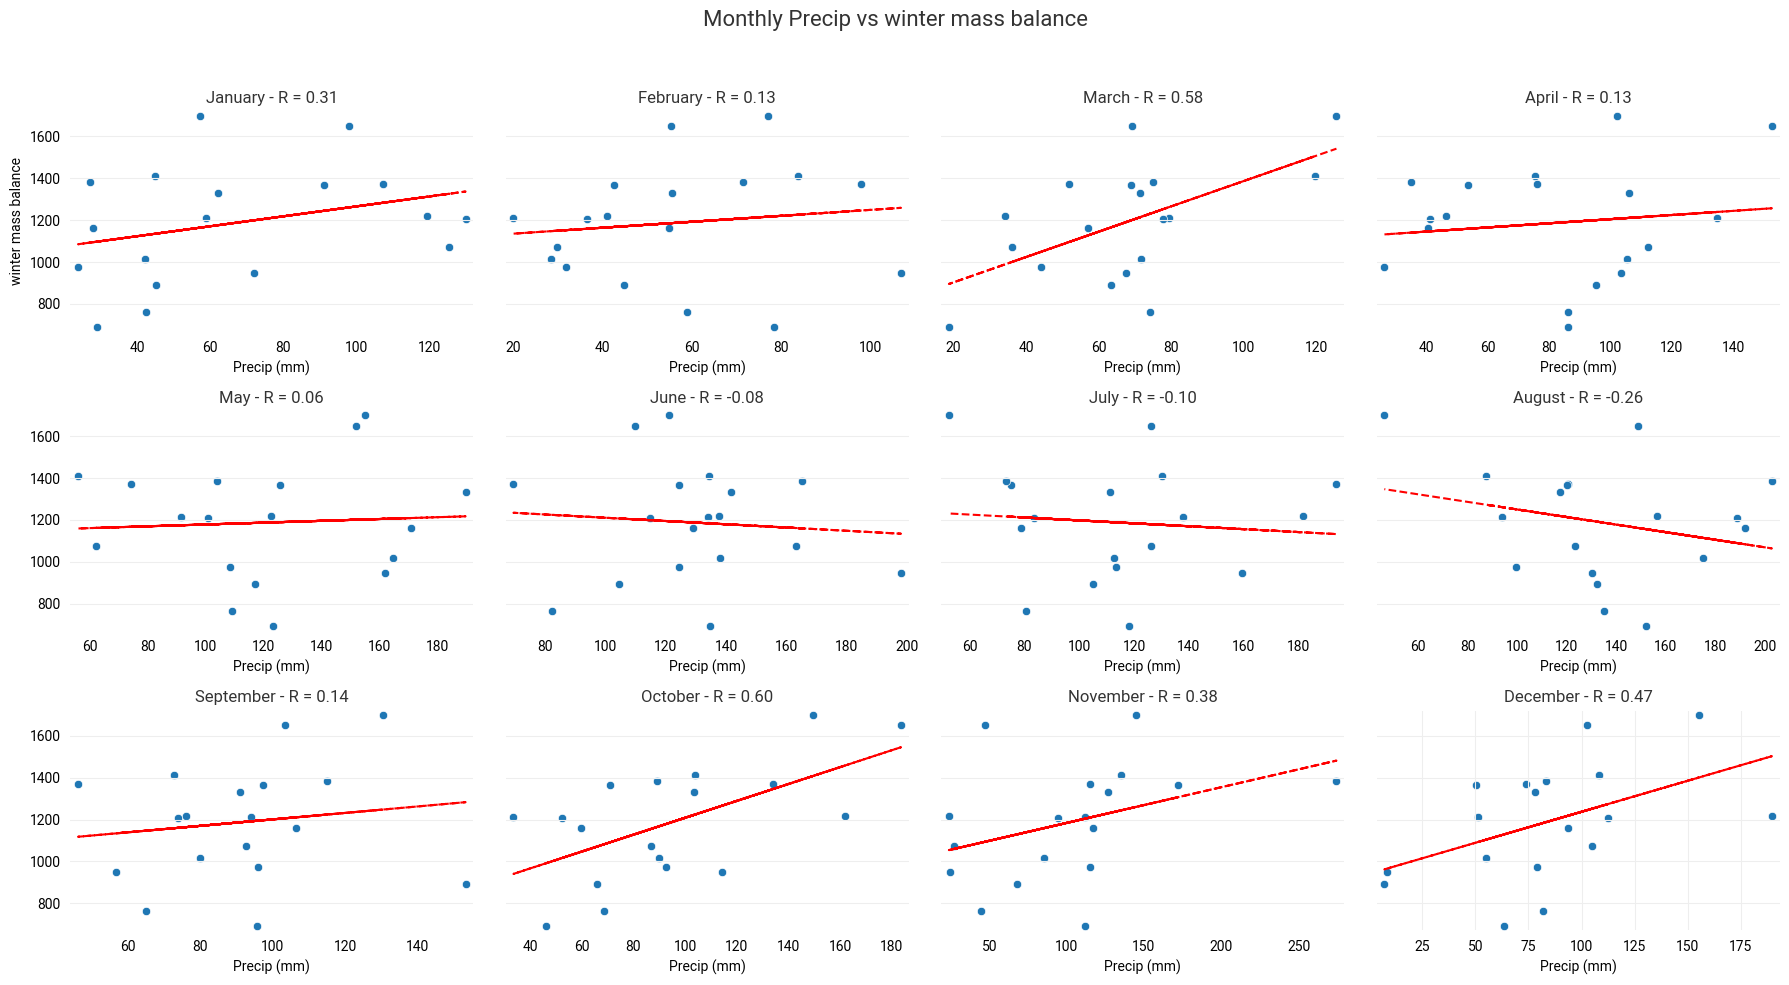

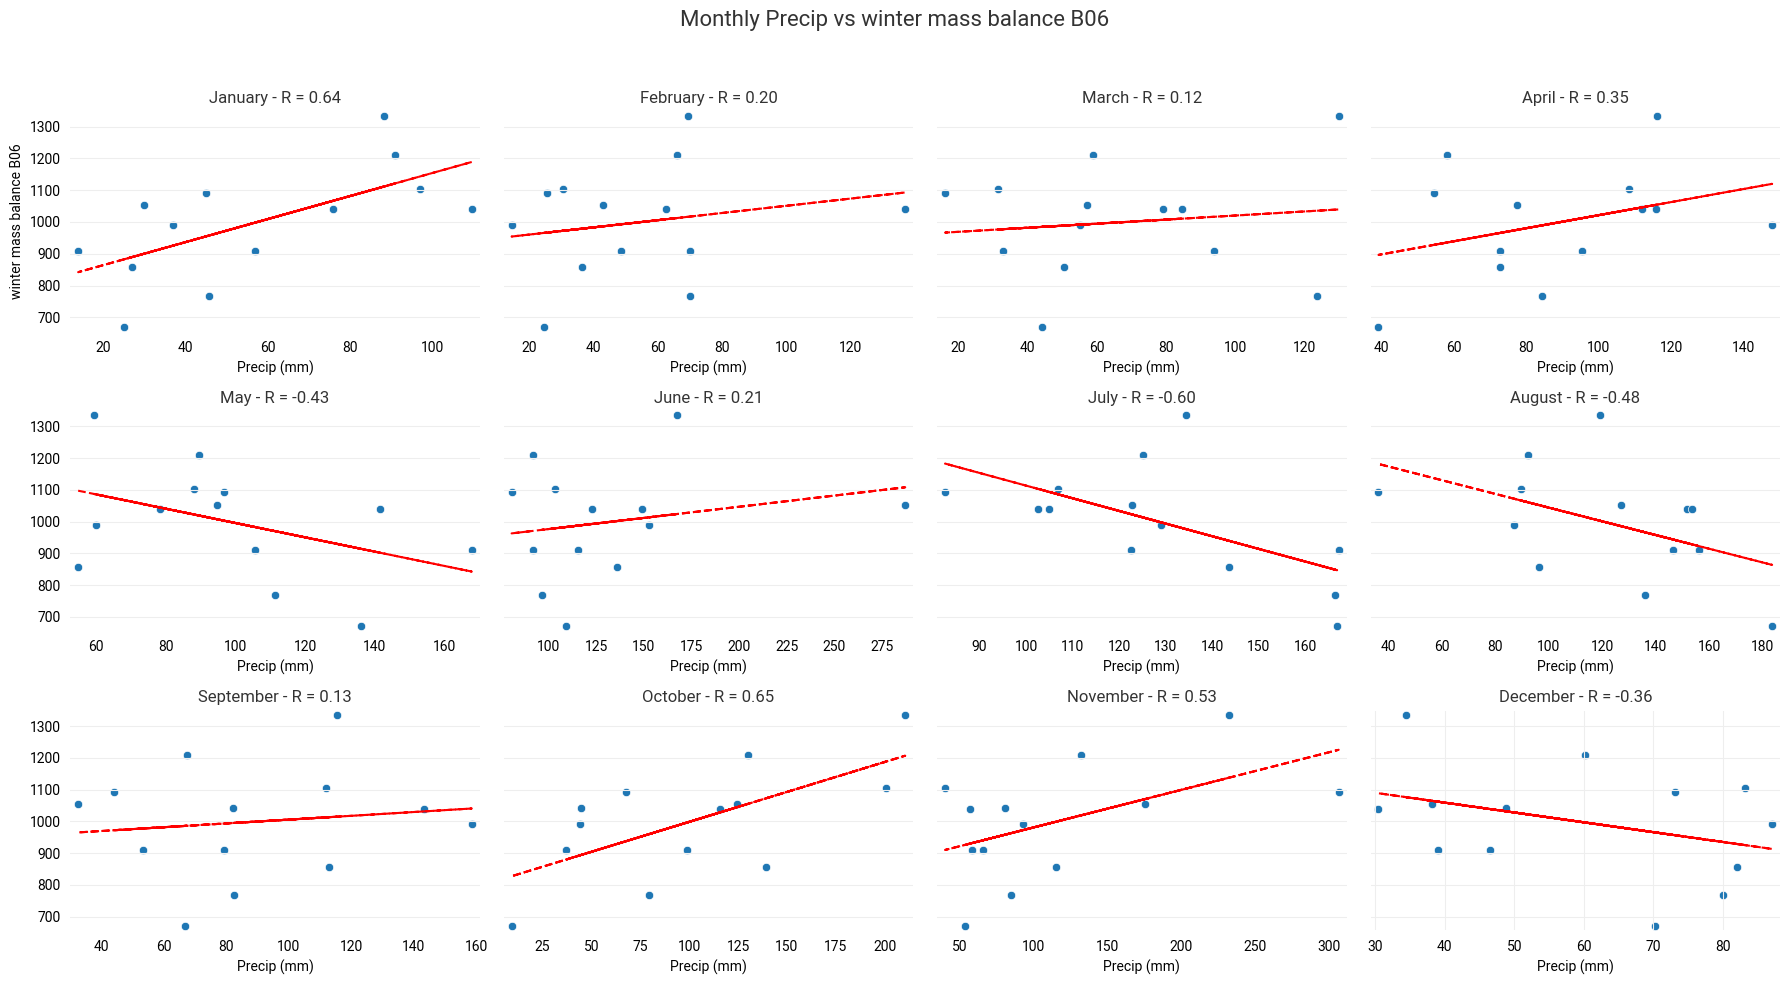

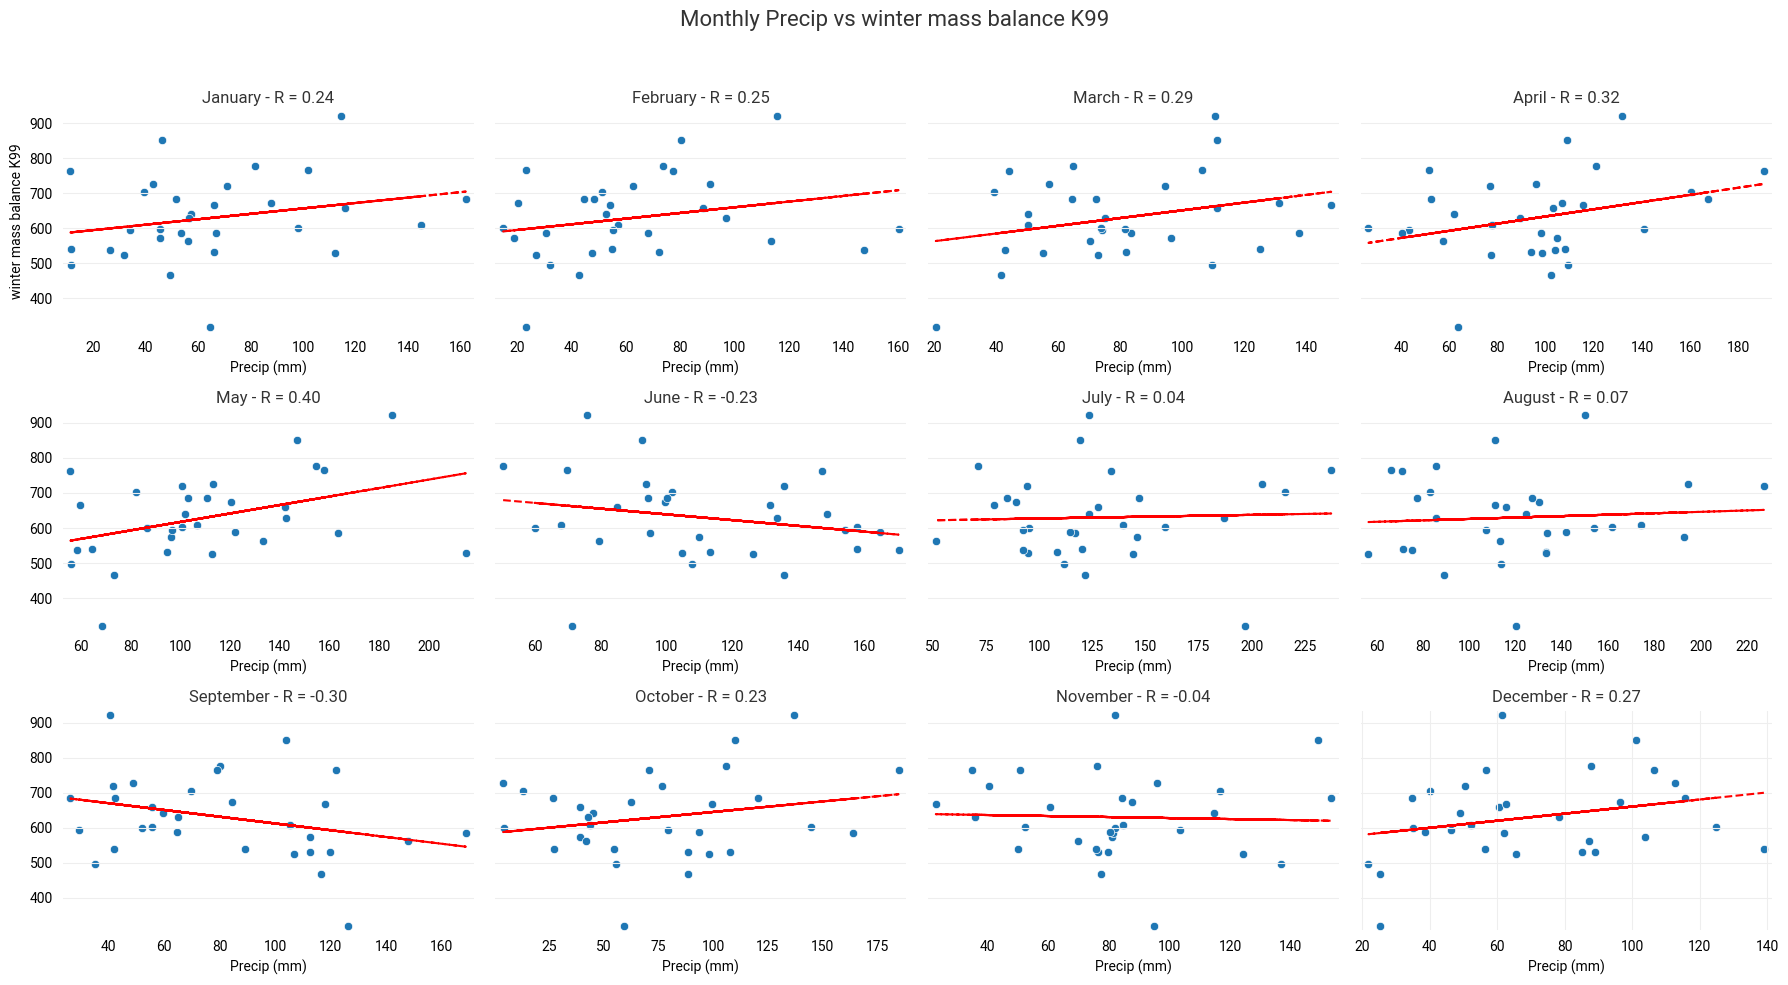

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import pandas as pd

# List of month names
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

mb_cols = [
    'mean specific mass balance',
    'climatic mass balance',
    'winter mass balance',
    'winter mass balance B06',
    'winter mass balance K99'
]

for mb_col in mb_cols:
    fig, axs = plt.subplots(3, 4, figsize=(18, 10), sharey=True)
    axs = axs.flatten()

    for month in range(1, 13):
        ax = axs[month - 1]
        df_temp = df_merged[df_merged["month"] == month]
        df_temp = df_temp.dropna(subset=["precipitation_mm", mb_col])  # Drop NaNs from this subset

        # Check if there is any valid data for plotting
        if df_temp.empty or df_temp[mb_col].isna().all():
            ax.set_title(f"{month_names[month-1]}\n(no data)")
            continue

        # Get precipitation and mass balance
        x = df_temp["precipitation_mm"]
        y = df_temp[mb_col]

        # Convert y to numeric, forcing errors to NaN
        y = pd.to_numeric(df_temp[mb_col], errors='coerce')

        # Drop NaNs and filter valid data
        valid = (~x.isna()) & (~y.isna())
        x_valid = x[valid]
        y_valid = y[valid]

        # Ensure there are at least two valid data points
        if len(x_valid) < 2:
            ax.set_title(f"{month_names[month-1]}\n(<2 pts)")
            continue

        # Scatter plot
        sns.scatterplot(x=x_valid, y=y_valid, ax=ax, color="tab:blue", label=None)

        # Perform linear regression and plot line of best fit
        try:
            slope, intercept, r_value, _, _ = linregress(x_valid, y_valid)
            ax.plot(x_valid, slope * x_valid + intercept, color="red", linestyle="--")
            ax.set_title(f"{month_names[month-1]} - R = {r_value:.2f}")
        except Exception as e:
            ax.set_title(f"{month_names[month-1]}\n(Error: {str(e)})")

        # Set labels only for the first month
        ax.set_xlabel("Precip (mm)")
        ax.set_ylabel(mb_col if month == 1 else "")  # Label only for the first month

    # Set a title for the entire figure
    plt.suptitle(f"Monthly Precip vs {mb_col}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.grid(True)
    plt.show()



Month 1 - x_valid type: <class 'pandas.core.series.Series'>, length: 63
Month 1 - y_valid type: <class 'pandas.core.series.Series'>, length: 63
Month 1 - x_valid values (first 5): 99     81.549881
111    45.318604
123    11.576653
135    53.388832
147    42.579887
Name: precipitation_mm, dtype: float32
Month 1 - y_valid values (first 5): 99     -696
111    -603
123   -1244
135     925
147     344
Name: mean specific mass balance, dtype: int64
Month 1 - x_valid range: 11.264324188232422 to 161.9381866455078
Month 1 - y_valid range: -3319 to 925
Month 2 - x_valid type: <class 'pandas.core.series.Series'>, length: 63
Month 2 - y_valid type: <class 'pandas.core.series.Series'>, length: 63
Month 2 - x_valid values (first 5): 100    73.611259
112    18.939018
124    32.149792
136    30.597687
148    91.142181
Name: precipitation_mm, dtype: float32
Month 2 - y_valid values (first 5): 100    -696
112    -603
124   -1244
136     925
148     344
Name: mean specific mass balance, dtype: int64
Mon

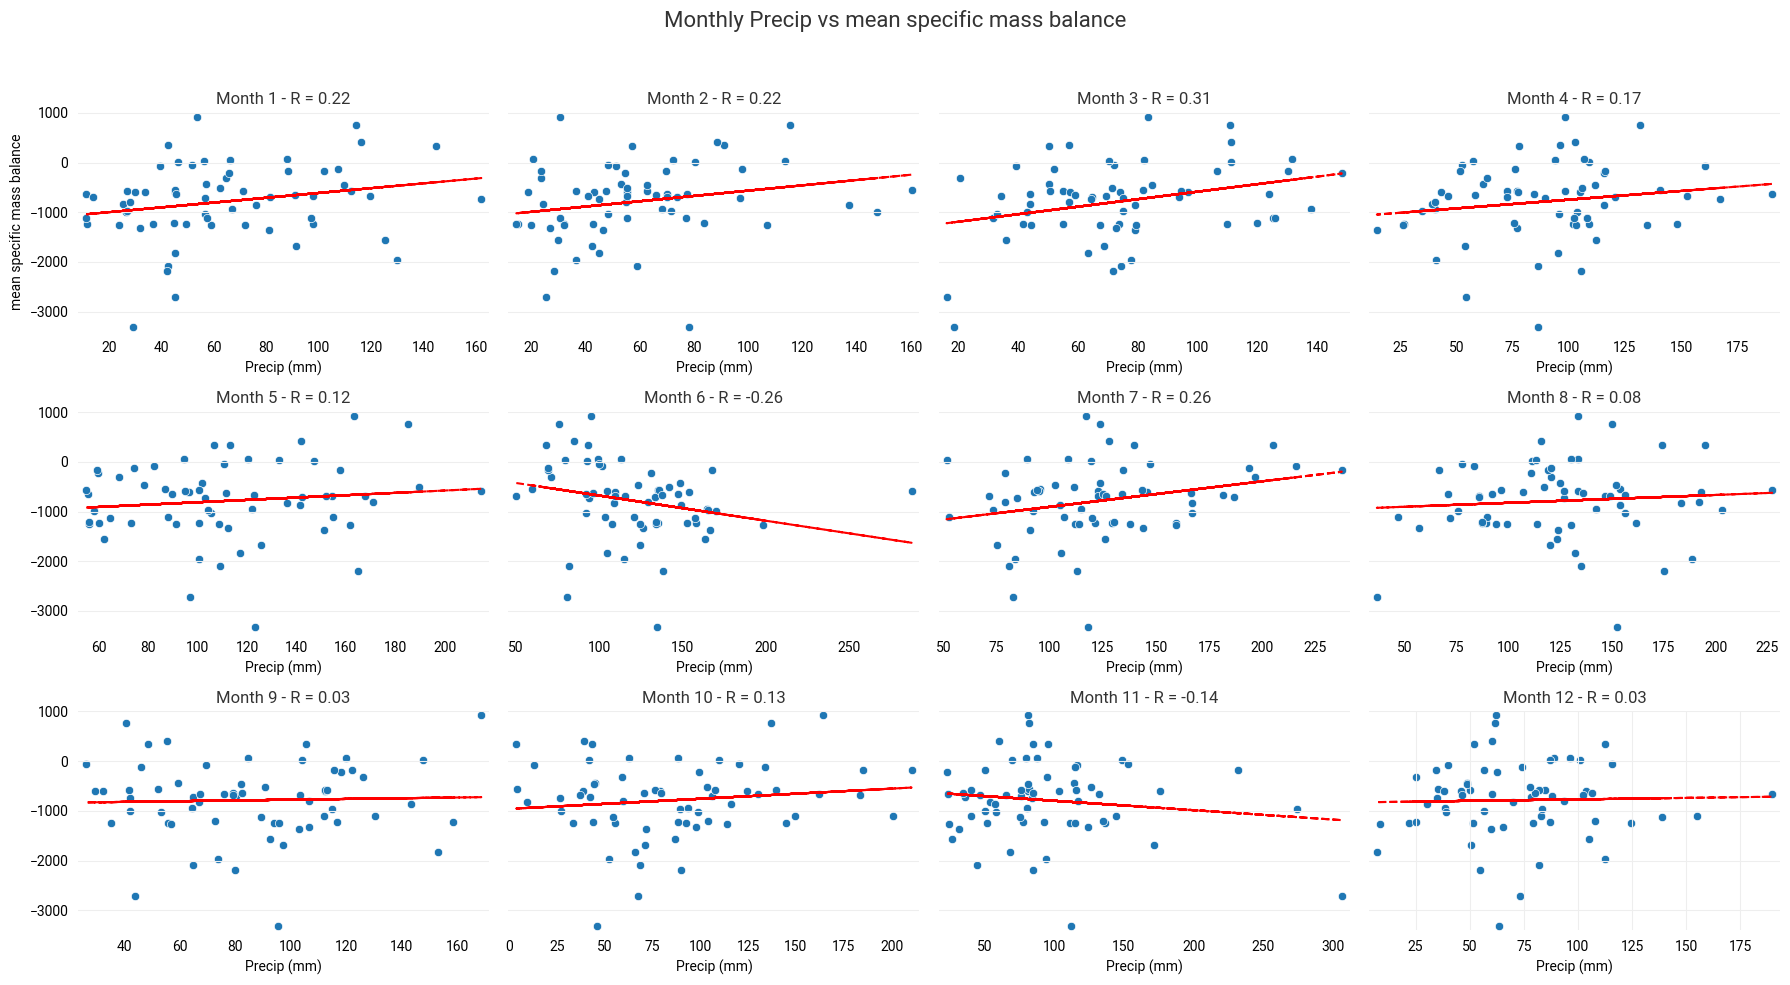

Month 1 - x_valid type: <class 'pandas.core.series.Series'>, length: 63
Month 1 - y_valid type: <class 'pandas.core.series.Series'>, length: 63
Month 1 - x_valid values (first 5): 99     81.549881
111    45.318604
123    11.576653
135    53.388832
147    42.579887
Name: precipitation_mm, dtype: float32
Month 1 - y_valid values (first 5): 99      -731
111     -662
123    -1314
135      868
147      293
Name: climatic mass balance, dtype: object
Month 1 - x_valid range: 11.264324188232422 to 161.9381866455078
Month 1 - y_valid range: -3673 to 868
Month 2 - x_valid type: <class 'pandas.core.series.Series'>, length: 63
Month 2 - y_valid type: <class 'pandas.core.series.Series'>, length: 63
Month 2 - x_valid values (first 5): 100    73.611259
112    18.939018
124    32.149792
136    30.597687
148    91.142181
Name: precipitation_mm, dtype: float32
Month 2 - y_valid values (first 5): 100     -731
112     -662
124    -1314
136      868
148      293
Name: climatic mass balance, dtype: object
M

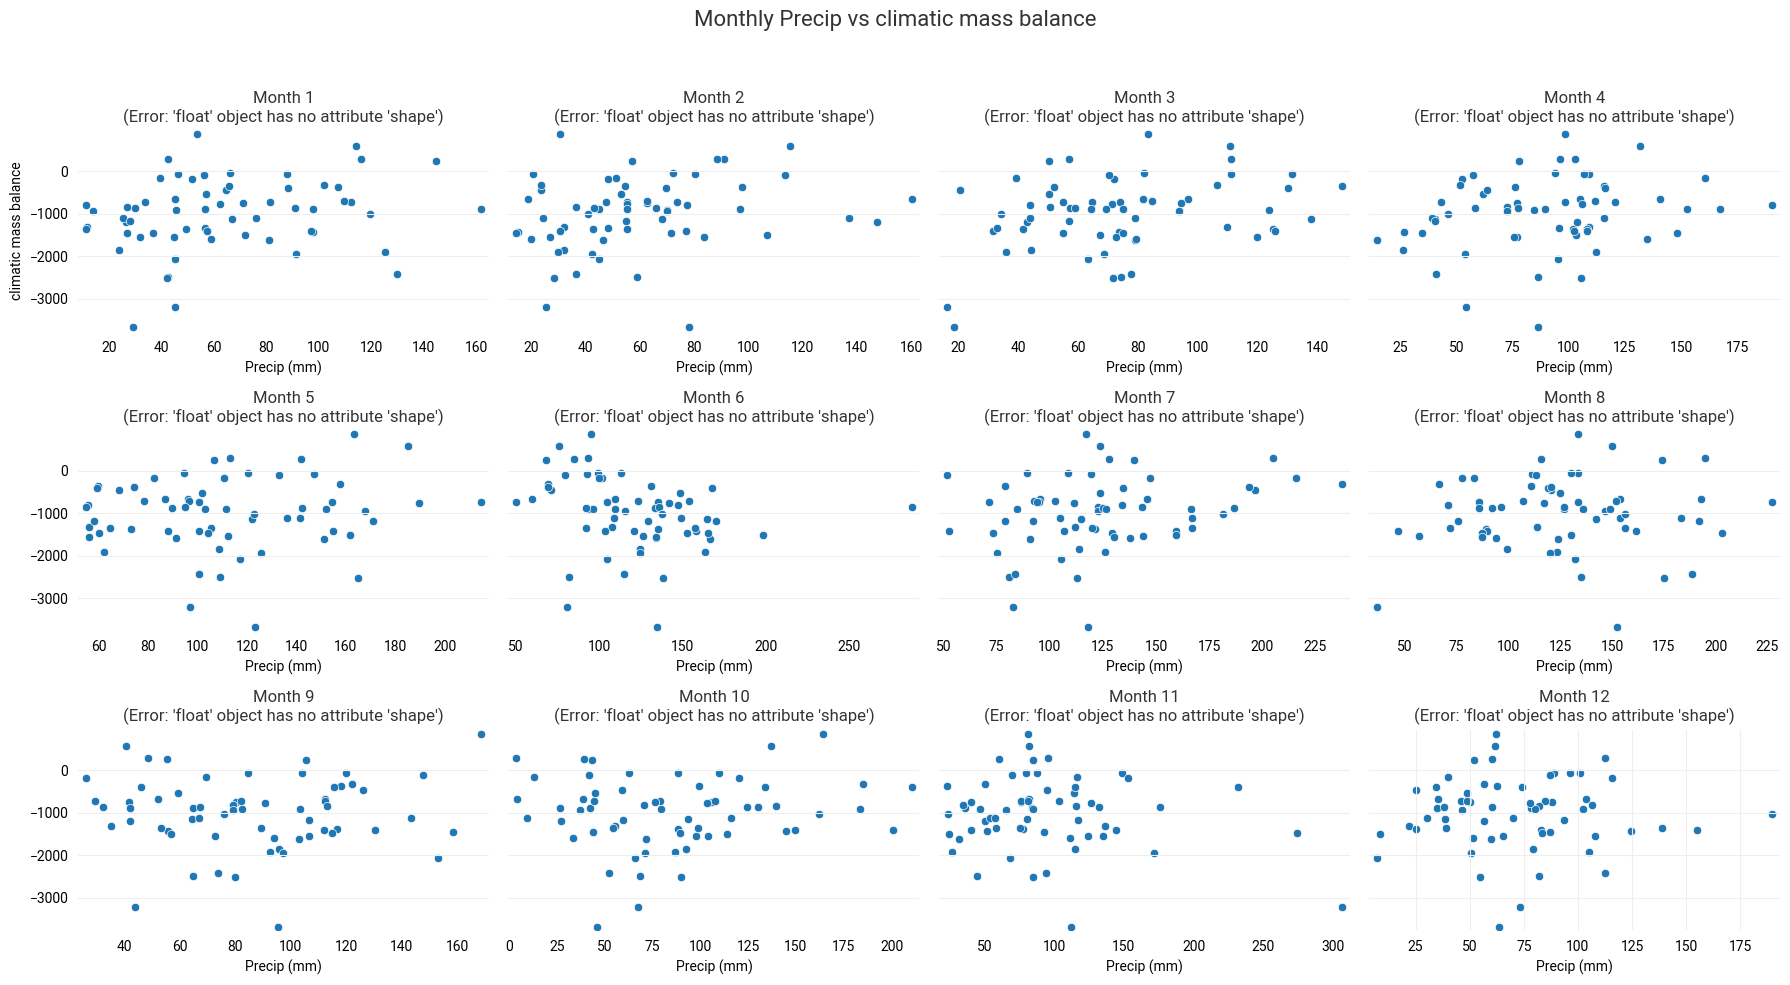

Month 1 - x_valid type: <class 'pandas.core.series.Series'>, length: 18
Month 1 - y_valid type: <class 'pandas.core.series.Series'>, length: 18
Month 1 - x_valid values (first 5): 627    42.483330
651    58.775185
663    44.796707
675    28.015614
687    23.826122
Name: precipitation_mm, dtype: float32
Month 1 - y_valid values (first 5): 627     764.0
651    1213.0
663    1411.0
675    1162.0
687     975.0
Name: winter mass balance, dtype: float64
Month 1 - x_valid range: 23.826122283935547 to 129.82272338867188
Month 1 - y_valid range: 691.0 to 1700.0
Month 2 - x_valid type: <class 'pandas.core.series.Series'>, length: 18
Month 2 - y_valid type: <class 'pandas.core.series.Series'>, length: 18
Month 2 - x_valid values (first 5): 628    58.780193
652    20.039558
664    83.701134
676    54.864407
688    31.874895
Name: precipitation_mm, dtype: float32
Month 2 - y_valid values (first 5): 628     764.0
652    1213.0
664    1411.0
676    1162.0
688     975.0
Name: winter mass balance, dtyp

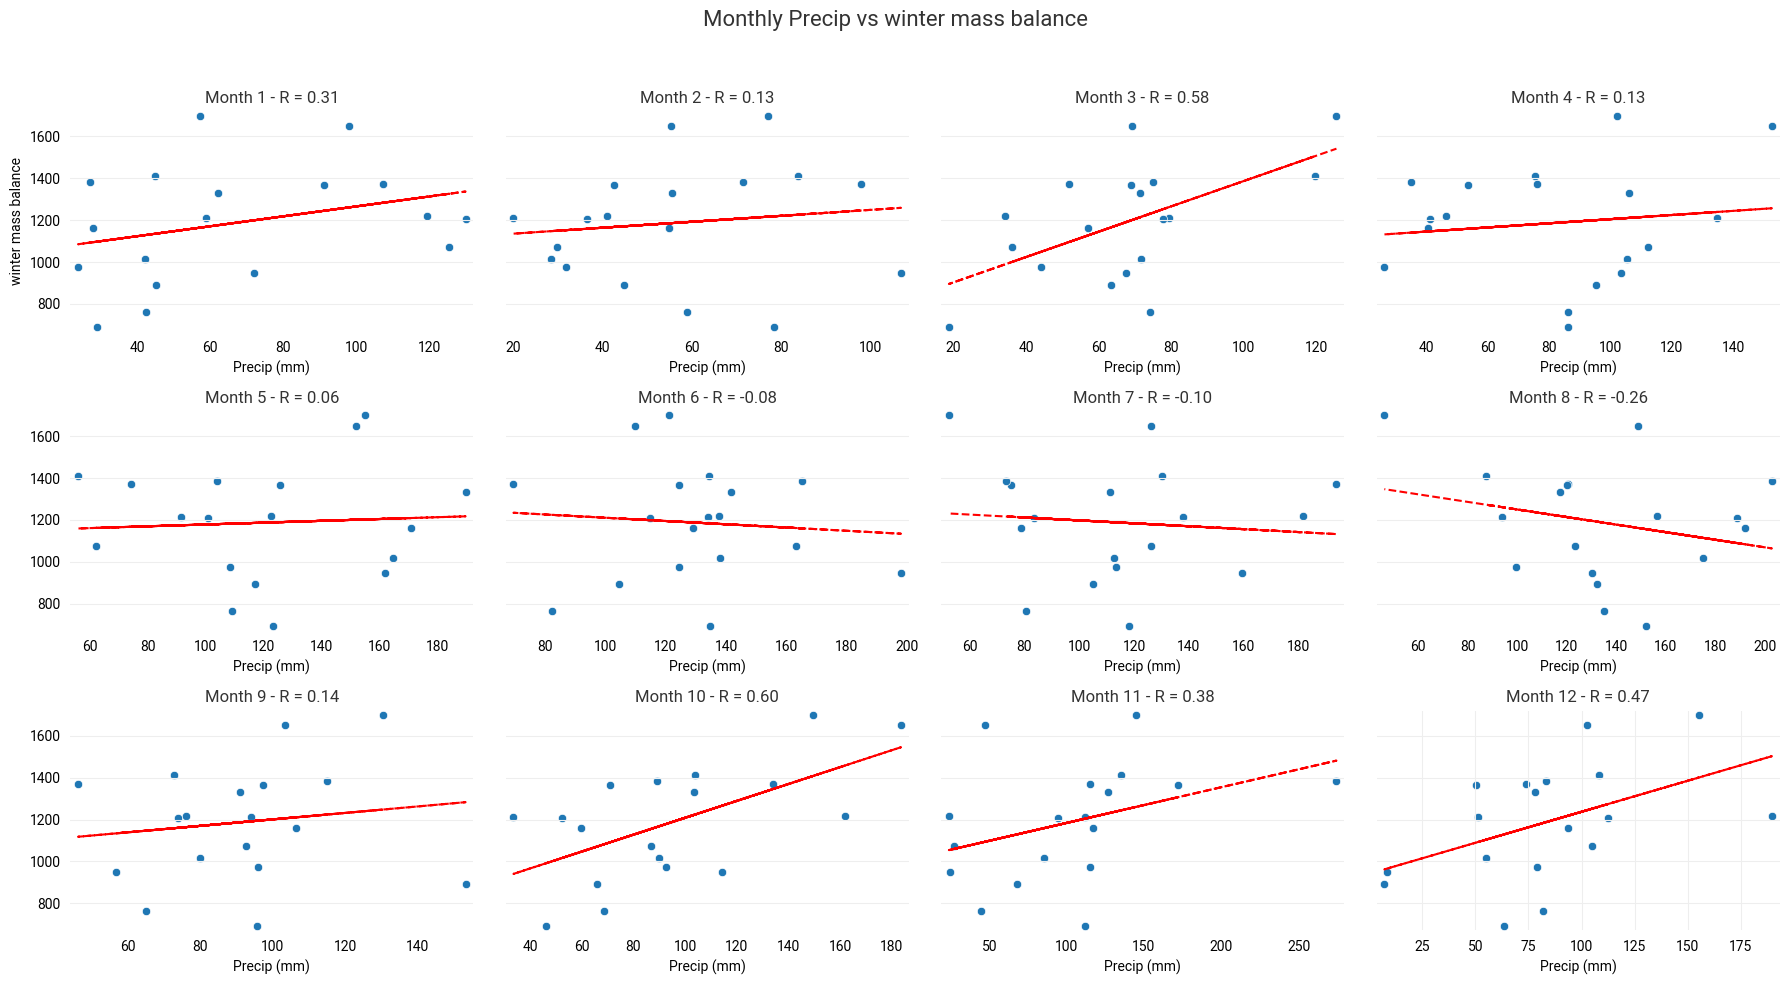

Month 1 - x_valid type: <class 'pandas.core.series.Series'>, length: 13
Month 1 - y_valid type: <class 'pandas.core.series.Series'>, length: 13
Month 1 - x_valid values (first 5): 471     26.990891
483     96.955299
495    109.482285
507     25.258780
519     29.933691
Name: precipitation_mm, dtype: float32
Month 1 - y_valid values (first 5): 471     857
483    1104
495    1041
507     670
519    1053
Name: winter mass balance B06, dtype: object
Month 1 - x_valid range: 14.034509658813477 to 109.48228454589844
Month 1 - y_valid range: 670 to 1335
Month 2 - x_valid type: <class 'pandas.core.series.Series'>, length: 13
Month 2 - y_valid type: <class 'pandas.core.series.Series'>, length: 13
Month 2 - x_valid values (first 5): 472    36.530018
484    30.389309
496    62.486172
508    24.422169
520    42.943718
Name: precipitation_mm, dtype: float32
Month 2 - y_valid values (first 5): 472     857
484    1104
496    1041
508     670
520    1053
Name: winter mass balance B06, dtype: object
Mo

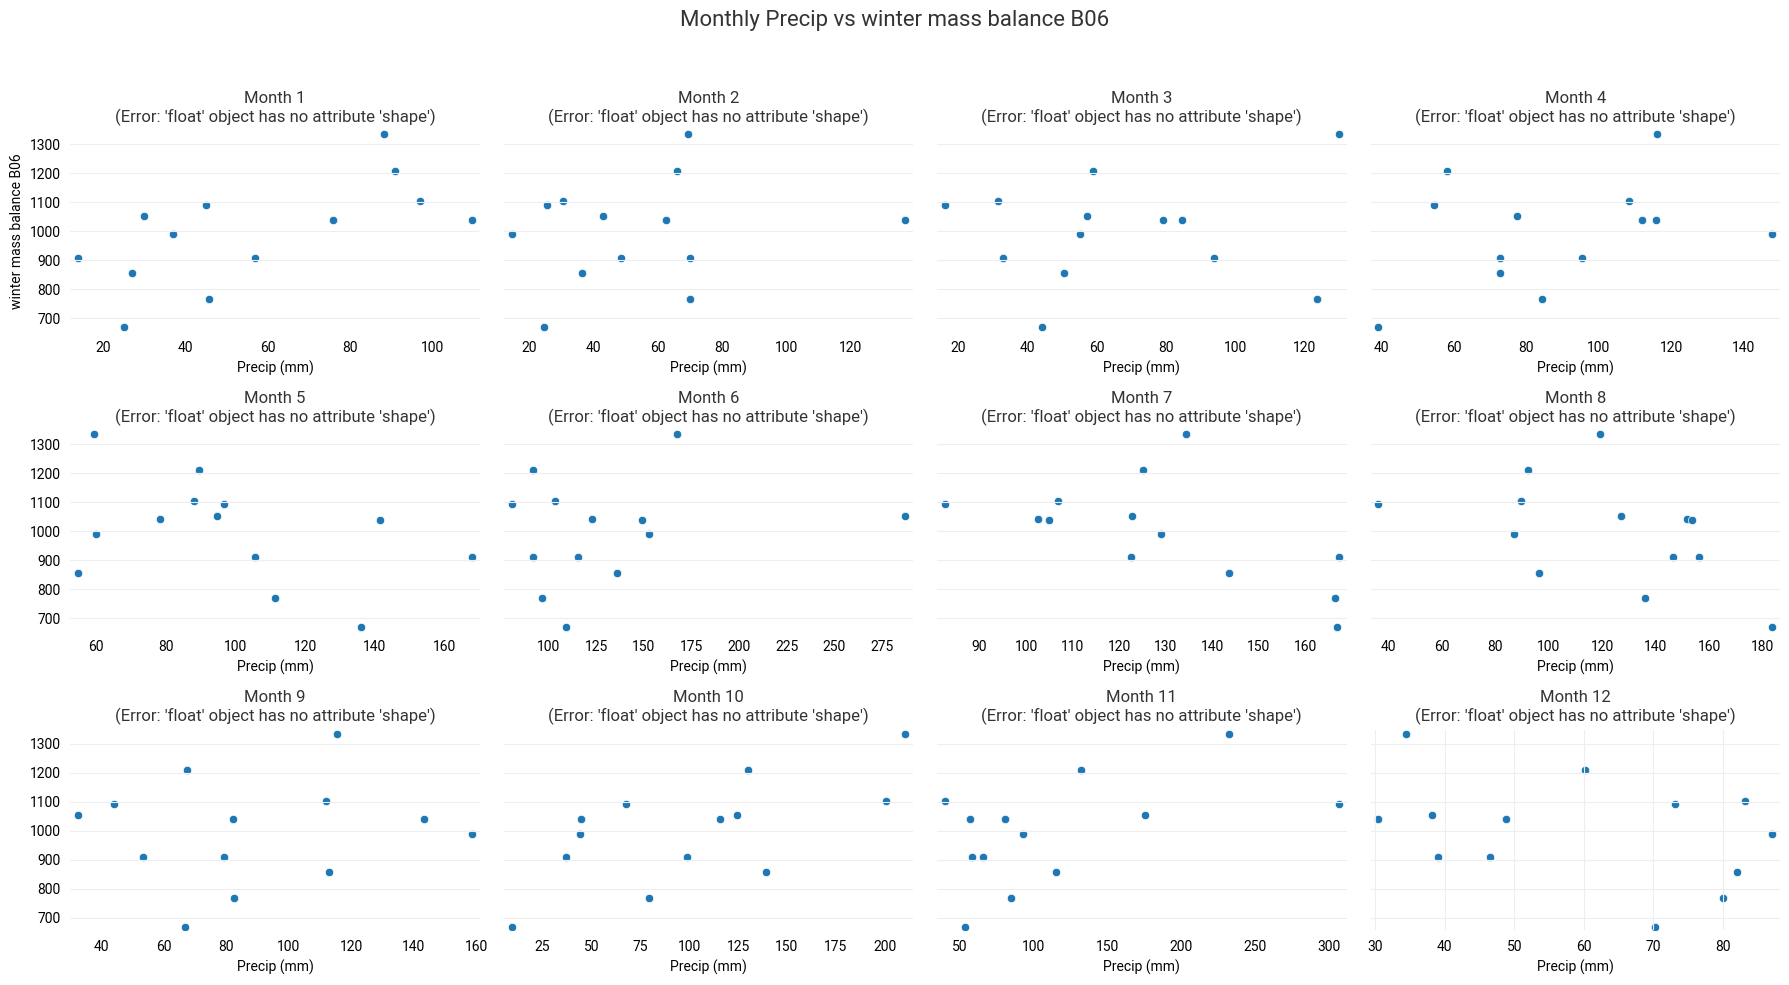

Month 1 - x_valid type: <class 'pandas.core.series.Series'>, length: 31
Month 1 - y_valid type: <class 'pandas.core.series.Series'>, length: 31
Month 1 - x_valid values (first 5): 99     81.549881
111    45.318604
123    11.576653
135    53.388832
147    42.579887
Name: precipitation_mm, dtype: float32
Month 1 - y_valid values (first 5): 99     777.0
111    573.0
123    496.0
135    586.0
147    727.0
Name: winter mass balance K99, dtype: float64
Month 1 - x_valid range: 11.264324188232422 to 161.9381866455078
Month 1 - y_valid range: 319.0 to 922.0
Month 2 - x_valid type: <class 'pandas.core.series.Series'>, length: 31
Month 2 - y_valid type: <class 'pandas.core.series.Series'>, length: 31
Month 2 - x_valid values (first 5): 100    73.611259
112    18.939018
124    32.149792
136    30.597687
148    91.142181
Name: precipitation_mm, dtype: float32
Month 2 - y_valid values (first 5): 100    777.0
112    573.0
124    496.0
136    586.0
148    727.0
Name: winter mass balance K99, dtype: f

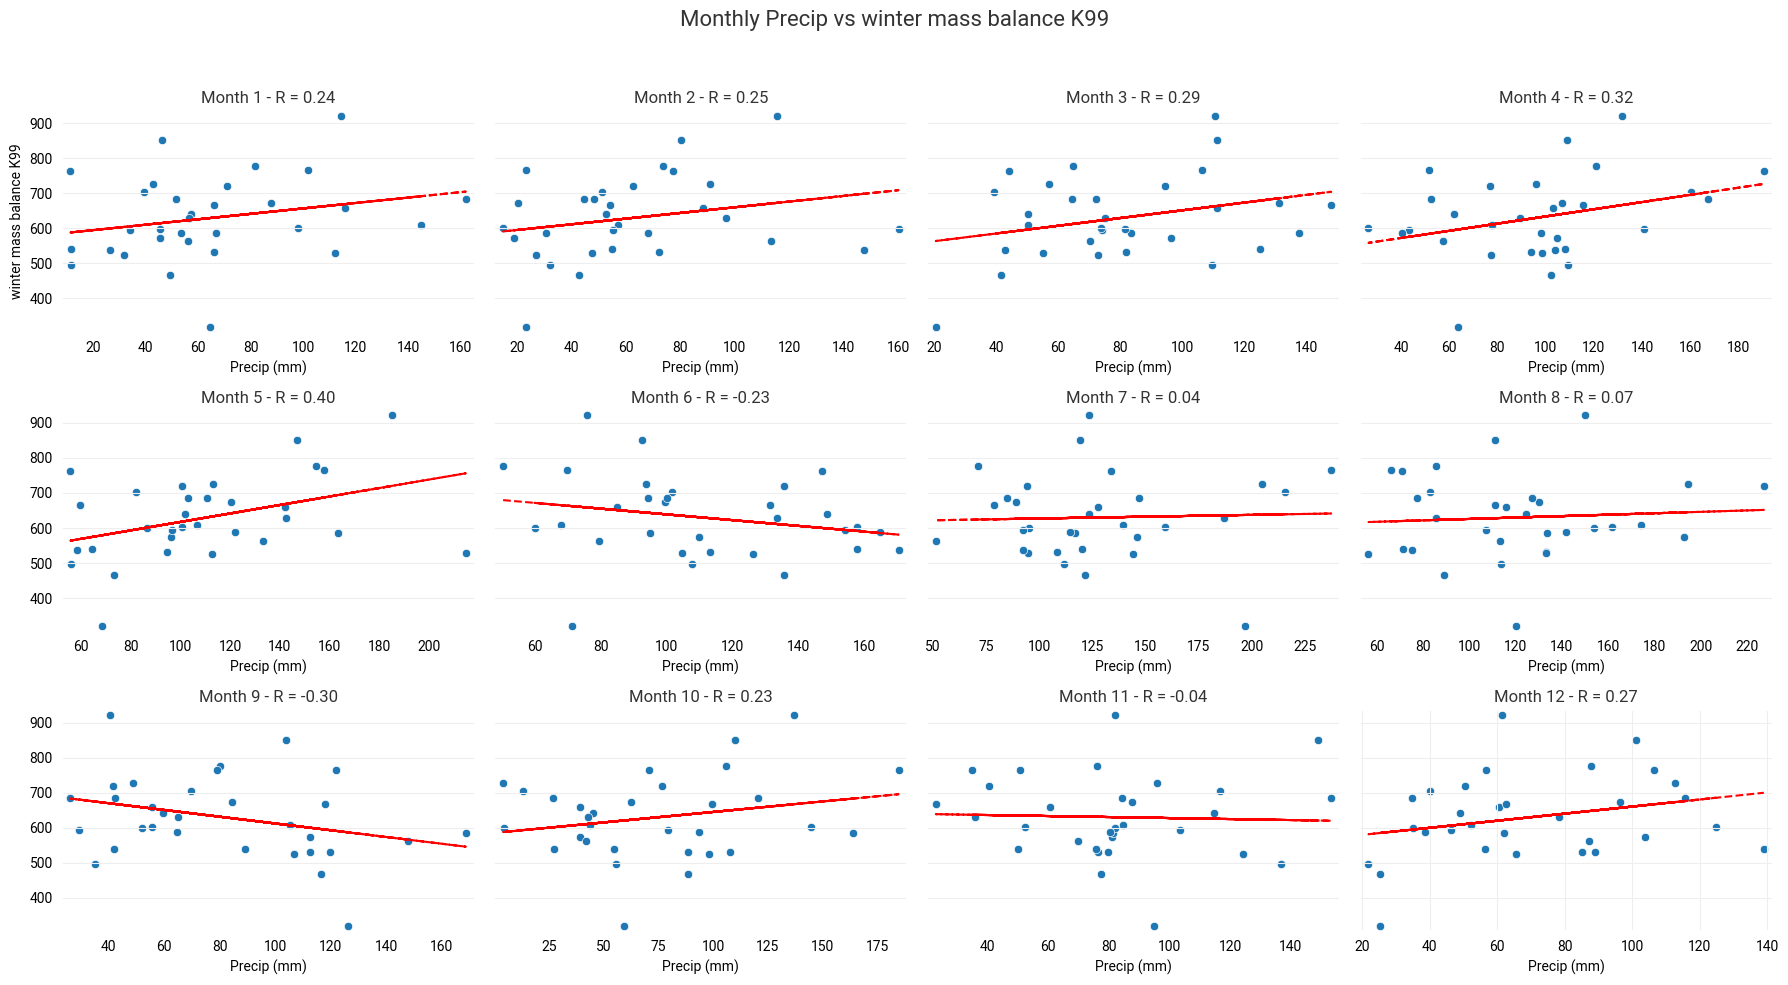

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

mb_cols = [
    'mean specific mass balance',
    'climatic mass balance',
    'winter mass balance',
    'winter mass balance B06',
    'winter mass balance K99'
]

for mb_col in mb_cols:
    fig, axs = plt.subplots(3, 4, figsize=(18, 10), sharey=True)
    axs = axs.flatten()

    for month in range(1, 13):
        ax = axs[month - 1]
        df_temp = df_merged[df_merged["month"] == month]
        df_temp = df_temp.dropna(subset=["precipitation_mm", mb_col])  # Drop NaNs from this subset

        # Check if there is any valid data for plotting
        if df_temp.empty or df_temp[mb_col].isna().all():
            ax.set_title(f"Month {month}\n(no data)")
            continue

        # Get precipitation and mass balance
        x = df_temp["precipitation_mm"]
        y = df_temp[mb_col]

        # Drop NaNs and filter valid data
        valid = (~x.isna()) & (~y.isna())
        x_valid = x[valid]
        y_valid = y[valid]

        # Ensure there are at least two valid data points
        if len(x_valid) < 2:
            ax.set_title(f"Month {month}\n(<2 pts)")
            continue

        # Debugging: check the types, values, and ranges of x_valid and y_valid
        print(f"Month {month} - x_valid type: {type(x_valid)}, length: {len(x_valid)}")
        print(f"Month {month} - y_valid type: {type(y_valid)}, length: {len(y_valid)}")
        print(f"Month {month} - x_valid values (first 5): {x_valid.head()}")
        print(f"Month {month} - y_valid values (first 5): {y_valid.head()}")
        print(f"Month {month} - x_valid range: {x_valid.min()} to {x_valid.max()}")
        print(f"Month {month} - y_valid range: {y_valid.min()} to {y_valid.max()}")

        # Ensure they are not scalar values
        if isinstance(x_valid, (np.ndarray, pd.Series)) and isinstance(y_valid, (np.ndarray, pd.Series)):
            # Scatter plot
            sns.scatterplot(x=x_valid, y=y_valid, ax=ax, color="tab:blue", label=None)

            # Perform linear regression and plot line of best fit
            try:
                slope, intercept, r_value, _, _ = linregress(x_valid, y_valid)
                ax.plot(x_valid, slope * x_valid + intercept, color="red", linestyle="--")
                ax.set_title(f"Month {month} - R = {r_value:.2f}")
            except Exception as e:
                ax.set_title(f"Month {month}\n(Error: {str(e)})")
        else:
            ax.set_title(f"Month {month}\n(Invalid data)")

        # Set labels only for the first month
        ax.set_xlabel("Precip (mm)")
        ax.set_ylabel(mb_col if month == 1 else "")  # Label only for the first month

    # Set a title for the entire figure
    plt.suptitle(f"Monthly Precip vs {mb_col}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.grid(True)
    plt.show()


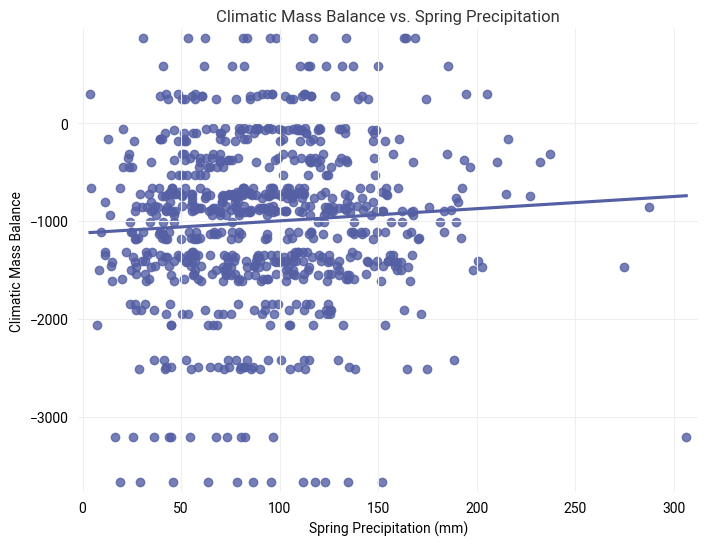

Correlation coefficient: 0.067


In [82]:
# Drop NaN values for plotting only, without modifying the original DataFrame
df_plot = df_merged.dropna(subset=["precipitation_mm", "climatic mass balance"])

# Now plot using the cleaned data
plt.figure(figsize=(8, 6))
sns.regplot(x=df_plot["precipitation_mm"], y=df_plot["climatic mass balance"], ci=None)  # ci=None removes confidence interval
plt.xlabel("Spring Precipitation (mm)")
plt.ylabel("Climatic Mass Balance")
plt.title("Climatic Mass Balance vs. Spring Precipitation")
plt.grid(True)
plt.show()

# Calculate correlation
correlation = df_plot["precipitation_mm"].corr(df_plot["climatic mass balance"])
print(f"Correlation coefficient: {correlation:.3f}")


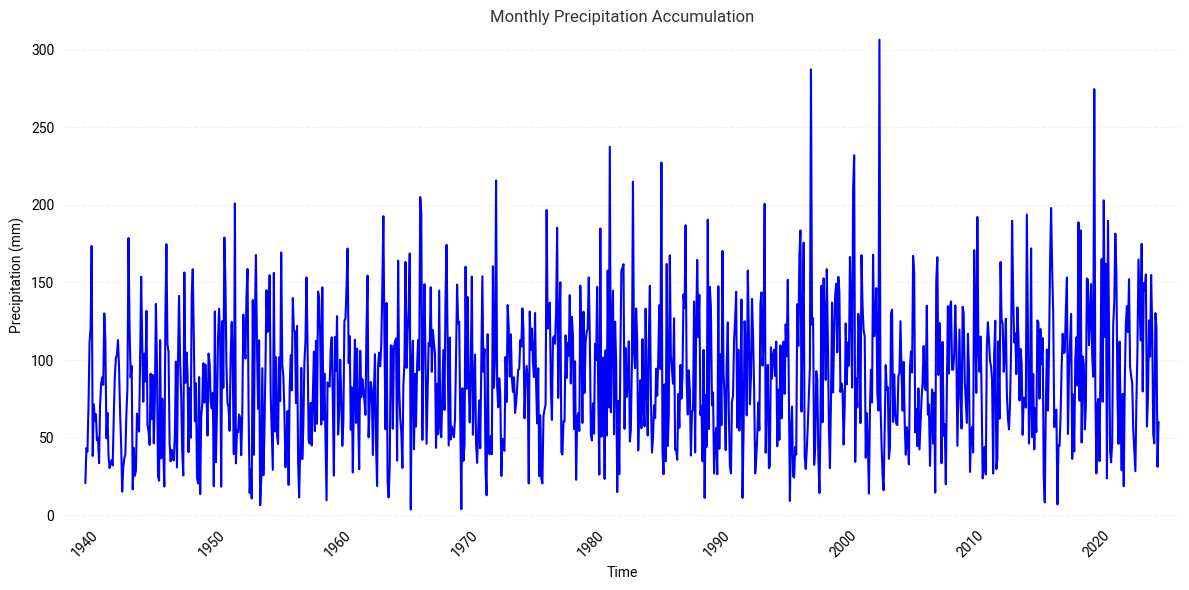

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly['Date'], df_monthly['precipitation_mm'], color='b')

# Title and labels
plt.title('Monthly Precipitation Accumulation')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')

# Add grid to the background
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

    year  annual_precipitation_mm
0   1940               865.650635
1   1941               839.217407
2   1942               793.813232
3   1943               826.156372
4   1944              1025.645264
..   ...                      ...
80  2020              1244.255371
81  2021              1136.453613
82  2022              1065.997070
83  2023              1367.491211
84  2024              1079.997559

[85 rows x 2 columns]


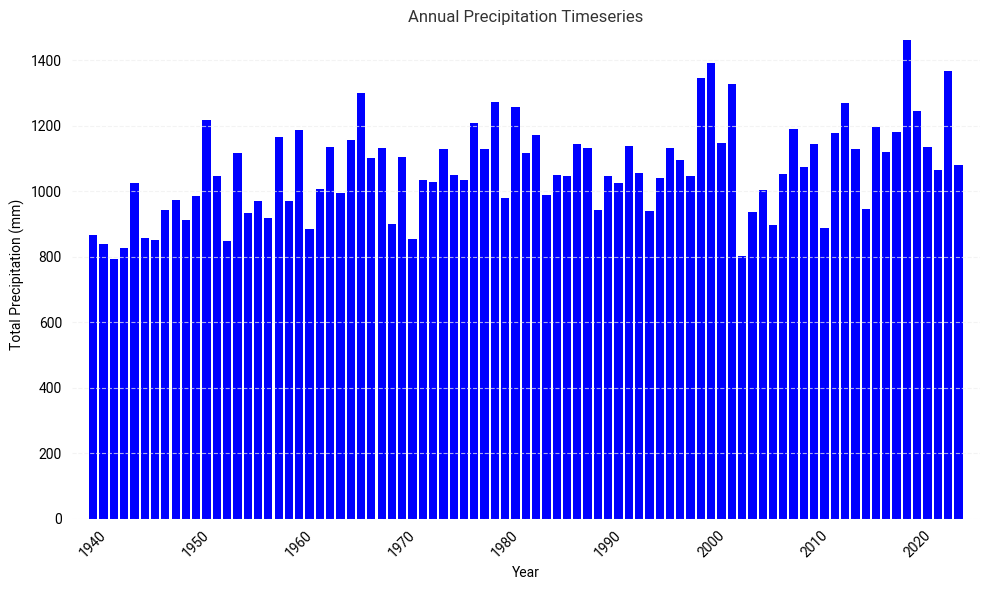

In [34]:
## This was just a sanity check to make sure I am using the right data. I compared this to the era5 explorer.


import pandas as pd
import matplotlib.pyplot as plt

def get_annual_precipitation(df):
    """
    Processes the monthly data and returns a DataFrame containing the annual precipitation sums.

    Args:
        df (pandas.DataFrame): DataFrame containing columns 'year', 'month', and 'precipitation_mm'.

    Returns:
        pandas.DataFrame: A DataFrame with the 'year' and the corresponding 'annual_precipitation_mm' values.
    """
    # Group by 'year' and sum the 'precipitation_mm' values to get the annual total
    annual_data = df.groupby('year')['precipitation_mm'].sum().reset_index()

    # Rename columns for clarity
    annual_data.columns = ['year', 'annual_precipitation_mm']

    return annual_data

def plot_annual_precipitation_bar(annual_data):
    """
    Plots the annual precipitation data as a bar plot with a grid in the background.

    Args:
        annual_data (pandas.DataFrame): DataFrame containing the 'year' and 'annual_precipitation_mm'.
    """
    # Plot the data as a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(annual_data['year'], annual_data['annual_precipitation_mm'], color='b')
    
    # Title and labels
    plt.title('Annual Precipitation Timeseries')
    plt.xlabel('Year')
    plt.ylabel('Total Precipitation (mm)')
    
    # Add grid to the background
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Assuming `df` is the DataFrame that contains 'year', 'month', and 'precipitation_mm' columns
annual_precipitation = get_annual_precipitation(df)

# Print the annual precipitation DataFrame (to check)
print(annual_precipitation)

# Now, plot the annual precipitation data outside the function
plot_annual_precipitation_bar(annual_precipitation)

